# Seattle Crime Trend Analysis & Forecasting


**Author:** Alexey Davydov

**Date:** May 2025

This notebook explores Seattle Police crime data from January 1, 2019 through May 10, 2025.  
I will perform:

1. Data cleaning & feature engineering  
2. Exploratory data analysis (e.g., weekly trends, day-of-week patterns, neighborhood volumes, category breakdown) 
3. Time-series forecasting with Prophet  
4. Conclusion & future steps

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.random.seed(42)
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 1. Data Preparation & Cleaning

In [2]:
df = pd.read_csv(
    "~/Desktop/Portfolio Projects/Seattle Crime Analysis & Forecasting/seattle_crime_2019-2025.csv",
    parse_dates=[
        "Report DateTime",
        "Offense Date"
    ]
)

In [3]:
df.shape

(528198, 19)

In [4]:
df.columns.tolist()
df.dtypes

Report Number                             object
Report DateTime                   datetime64[ns]
Offense ID                                 int64
Offense Date                      datetime64[ns]
NIBRS Group AB                            object
NIBRS Crime Against Category              object
Offense Sub Category                      object
Shooting Type Group                       object
Block Address                            float64
Latitude                                 float64
Longitude                                float64
Beat                                      object
Precinct                                  object
Sector                                    object
Neighborhood                              object
Reporting Area                           float64
Offense Category                          object
NIBRS Offense Code Description            object
NIBRS_offense_code                        object
dtype: object

In [5]:
df.isna().sum()

Report Number                          0
Report DateTime                        0
Offense ID                             0
Offense Date                           0
NIBRS Group AB                         0
NIBRS Crime Against Category           0
Offense Sub Category                   0
Shooting Type Group                    0
Block Address                     528198
Latitude                          528198
Longitude                         528198
Beat                                   0
Precinct                               0
Sector                                 0
Neighborhood                           0
Reporting Area                    528198
Offense Category                       0
NIBRS Offense Code Description         0
NIBRS_offense_code                     0
dtype: int64

In [6]:
df.head(5)

,Report Number,Report DateTime,Offense ID,Offense Date,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,Latitude,Longitude,Beat,Precinct,Sector,Neighborhood,Reporting Area,Offense Category,NIBRS Offense Code Description,NIBRS_offense_code
0,2020-198239,2020-06-27 11:07:53,13754826455,2019-01-01,A,PERSON,ASSAULT OFFENSES,-,NaN,NaN,NaN,D1,West,D,BELLTOWN,NaN,ALL OTHER,Intimidation,13C
1,2019-174994,2019-05-16 03:00:10,8302557744,2019-01-01,A,PROPERTY,EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD ...,-,NaN,NaN,NaN,99,OOJ,99,UNKNOWN,NaN,ALL OTHER,False Pretenses/Swindle/Confidence Game,26A
2,2019-226638,2019-06-21 13:33:53,8342109404,2019-01-01,A,PERSON,ASSAULT OFFENSES,-,NaN,NaN,NaN,G2,East,G,CENTRAL AREA/SQUIRE PARK,NaN,ALL OTHER,Simple Assault,13B
3,2021-287163,2021-10-29 12:42:48,29492566384,2019-01-01,A,PERSON,ASSAULT OFFENSES,-,NaN,NaN,NaN,L1,North,L,NORTHGATE,NaN,ALL OTHER,Intimidation,13C
4,2019-902779,2019-03-13 16:08:00,7640345037,2019-01-01,A,PROPERTY,EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD ...,-,NaN,NaN,NaN,K3,West,K,DOWNTOWN COMMERCIAL,NaN,ALL OTHER,Impersonation,26C


In [7]:
df = df.drop(columns=[
    "Block Address",
    "Latitude",
    "Longitude",
    "Reporting Area"
])

In [8]:
df["date"]        = df["Offense Date"].dt.date
df["year_week"]   = df["Offense Date"].dt.to_period("W").astype(str)
df["day_of_week"] = df["Offense Date"].dt.day_name()
df["month"]       = df["Offense Date"].dt.month
df["year"]        = df["Offense Date"].dt.year

In [9]:
#Aggregate to weekly counts
weekly = (
    df.set_index("Offense Date")
      .resample("W", label="left")
      .size()
      .reset_index(name="count")
      .rename(columns={"Offense Date":"ds"})
)

weekly = weekly.iloc[:-1]

## 2. Exploratory Data Analysis

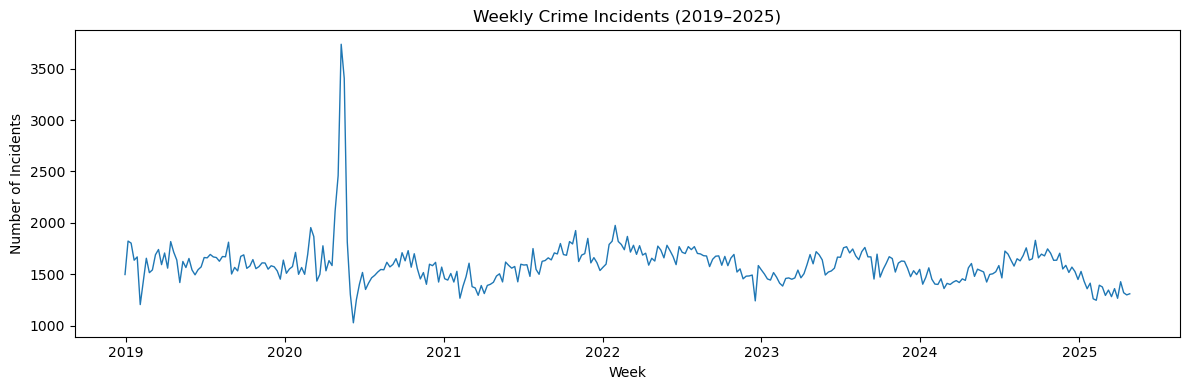

In [10]:
#Plot total weekly incidents
plt.figure(figsize=(12,4))
plt.plot(weekly["ds"], weekly["count"], linewidth=1)
plt.title("Weekly Crime Incidents (2019–2025)")
plt.xlabel("Week")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.show()

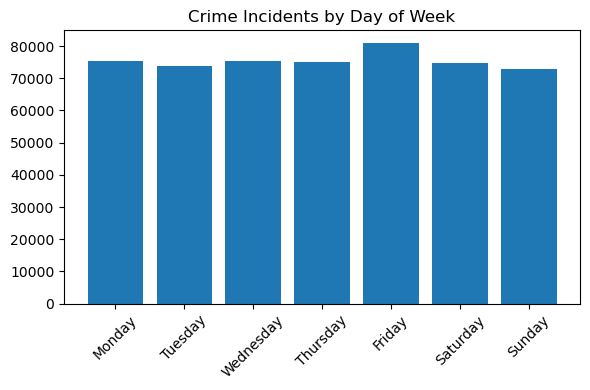

In [11]:
#Count by day of week
dow = (
    df["day_of_week"]
      .value_counts()
      .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
)

plt.figure(figsize=(6,4))
plt.bar(dow.index, dow.values)
plt.title("Crime Incidents by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

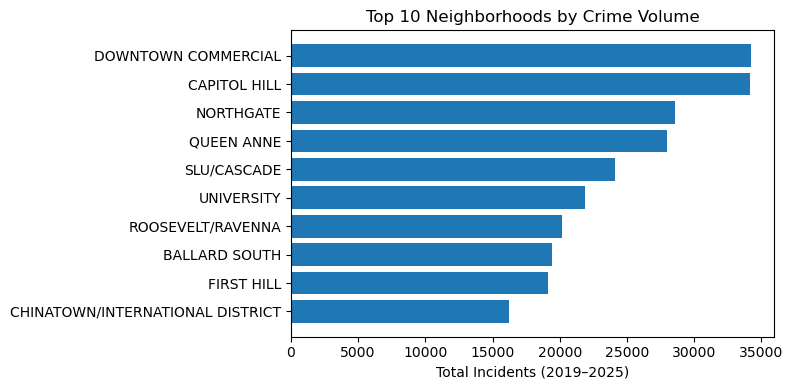

In [12]:
#Top 10 neighborhoods by total incidents
top_nbrhd = (
    df["Neighborhood"]
      .value_counts()
      .head(10)
)

plt.figure(figsize=(8,4))
plt.barh(top_nbrhd.index[::-1], top_nbrhd.values[::-1])
plt.title("Top 10 Neighborhoods by Crime Volume")
plt.xlabel("Total Incidents (2019–2025)")
plt.tight_layout()
plt.show()

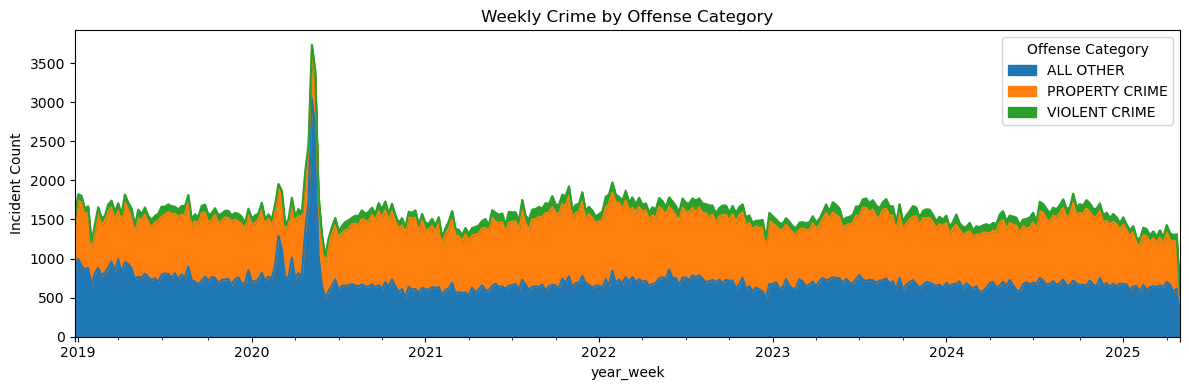

In [13]:
#Group by week + offense category
cat_weekly = (
    df.groupby(["year_week", "Offense Category"])
      .size()
      .reset_index(name="count")
)


pivot = cat_weekly.pivot(
    index="year_week",
    columns="Offense Category",
    values="count"
).fillna(0)


pivot.index = (
    pd.PeriodIndex(pivot.index, freq="W")
      .to_timestamp()
)


pivot.plot.area(figsize=(12,4))
plt.title("Weekly Crime by Offense Category")
plt.ylabel("Incident Count")
plt.tight_layout()
plt.show()

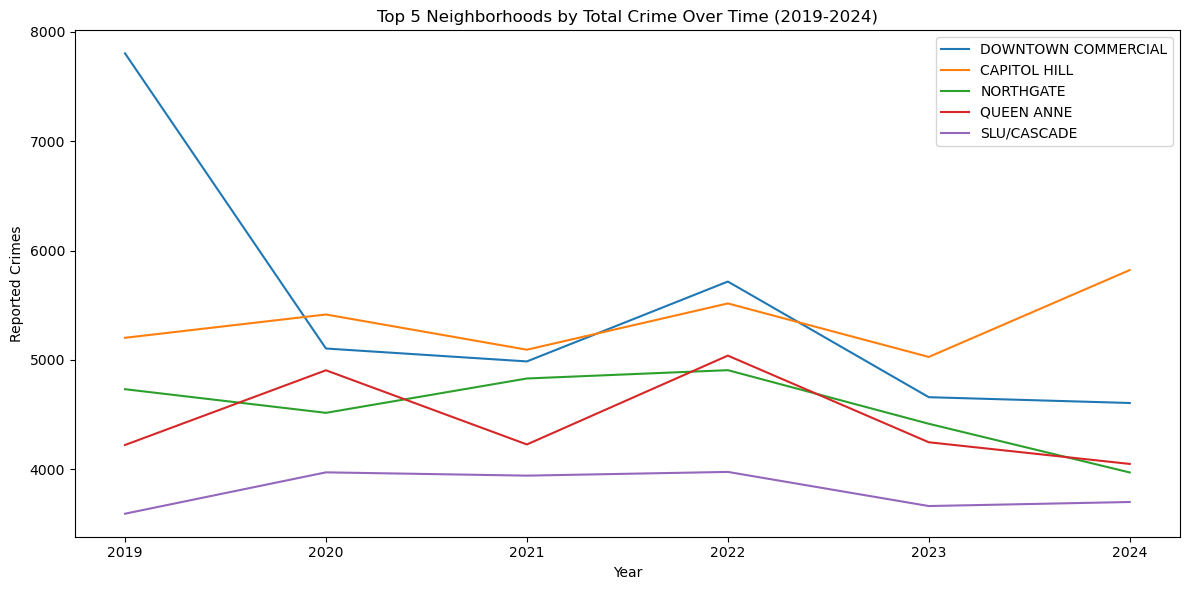

In [14]:
#Group by Neighborhood and Year, and count incidents
yearly_crime = df.groupby(['Neighborhood', 'year']).size().reset_index(name='Total Crimes')

#Only data 2019-2024
yearly_crime = yearly_crime[yearly_crime['year'].between(2019, 2024)]

#Identify top 5 neighborhoods with highest overall crime
top5_neighborhoods = (
    yearly_crime.groupby('Neighborhood')['Total Crimes']
    .sum()
    .nlargest(5)
    .index
)

#Filter data for just top 5
top5_data = yearly_crime[yearly_crime['Neighborhood'].isin(top5_neighborhoods)]

#Plotting
plt.figure(figsize=(12, 6))
for neighborhood in top5_neighborhoods:
    subset = top5_data[top5_data['Neighborhood'] == neighborhood]
    plt.plot(subset['year'], subset['Total Crimes'], label=neighborhood)

plt.title("Top 5 Neighborhoods by Total Crime Over Time (2019-2024)")
plt.xlabel("Year")
plt.ylabel("Reported Crimes")
plt.legend()
plt.tight_layout()
plt.show()

#Identify top 10 sub-categories, excluding '999' placeholder
top_subcats = (
    df["Offense Sub Category"]
      .loc[lambda s: s != "999"] #drop placeholder
      .value_counts()
      .head(10)
      .index
      .tolist()
)

print("Top 10 sub-categories:", top_subcats)


df_top = df[df["Offense Sub Category"].isin(top_subcats)].copy()
df_top["year"] = df_top["Offense Date"].dt.year

annual_counts = (
    df_top
      .groupby(["year", "Offense Sub Category"])
      .size()
      .unstack(fill_value=0)
)

#Drop 2025 (partial) and keep only our top 10 in that order
annual_counts = annual_counts.loc[annual_counts.index < 2025, top_subcats]

ax = annual_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6),
    width=0.8
)
ax.set_title("Annual Counts of Top 10 Offense Sub-Categories (2019–2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Incidents")
ax.legend(title="Sub-Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

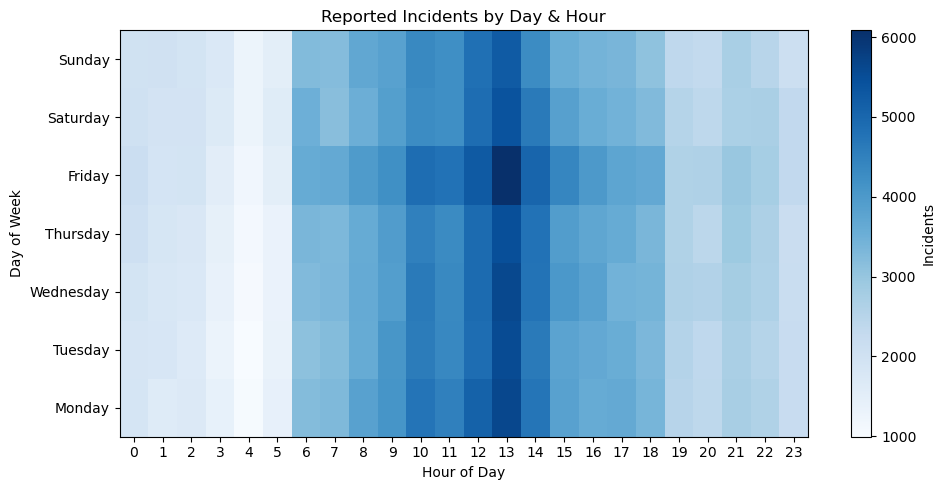

In [15]:
heat_data = (
    df.assign(hour=df["Report DateTime"].dt.hour)
      .pivot_table(
          index="day_of_week",
          columns="hour",
          values="Report Number",
          aggfunc="count",
          fill_value=0
      )
      .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
)

plt.figure(figsize=(10,5))
plt.pcolormesh(heat_data, cmap="Blues")
plt.title("Reported Incidents by Day & Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.xticks(np.arange(0.5,24.5), range(24))
plt.yticks(np.arange(0.5,7.5), heat_data.index)
plt.colorbar(label="Incidents")
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

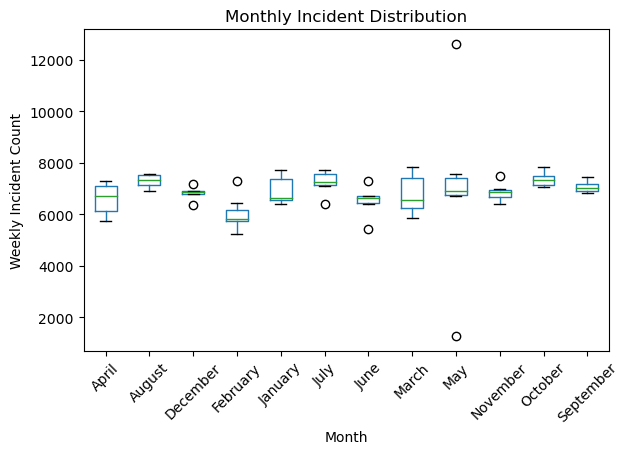

In [16]:
monthly = (
    df.set_index("Offense Date")
      .resample("M")
      .size()
      .reset_index(name="count")
      .assign(month=lambda d: d["Offense Date"].dt.month_name())
)

plt.figure(figsize=(8,4))
monthly.boxplot(column="count", by="month",
               grid=False,
               rot=45)
plt.suptitle("")
plt.title("Monthly Incident Distribution")
plt.xlabel("Month")
plt.ylabel("Weekly Incident Count")
plt.tight_layout()
plt.show()

## 3. Time-Series Crime Forecasting

21:55:08 - cmdstanpy - INFO - Chain [1] start processing
21:55:08 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.02, 'Baseline 12-Week Crime Forecast')

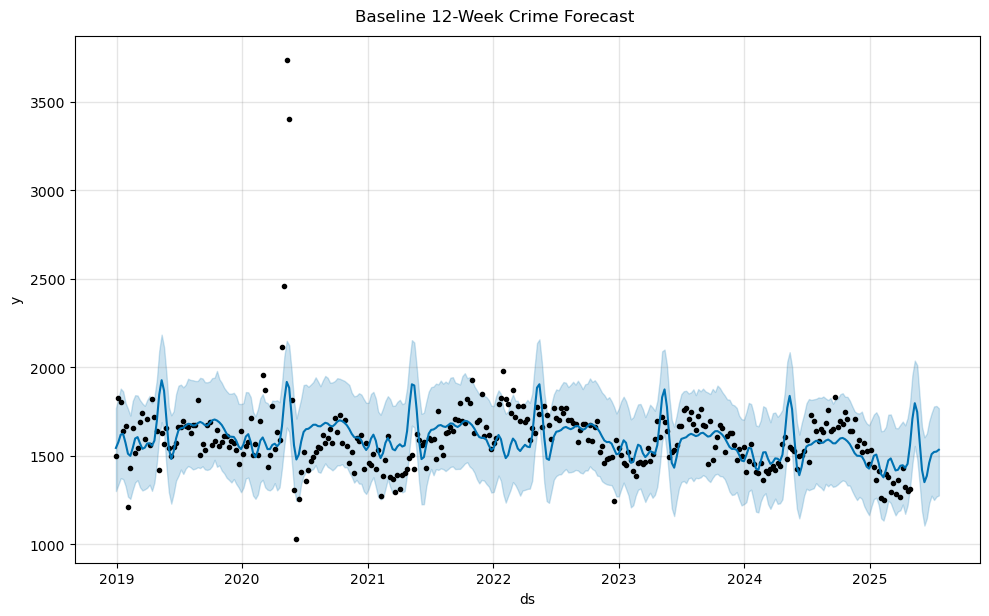

In [17]:
#Prepare DataFrame
prophet_df = weekly.rename(columns={"ds":"ds","count":"y"})

#Instantiate & fit
m_base = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False
)
m_base.fit(prophet_df)

#Forecast next 12 weeks
future_base   = m_base.make_future_dataframe(periods=12, freq="W")
forecast_base = m_base.predict(future_base)

#Standard Prophet plot (history + forecast)
fig1 = m_base.plot(forecast_base)
fig1.suptitle("Baseline 12-Week Crime Forecast", y=1.02)

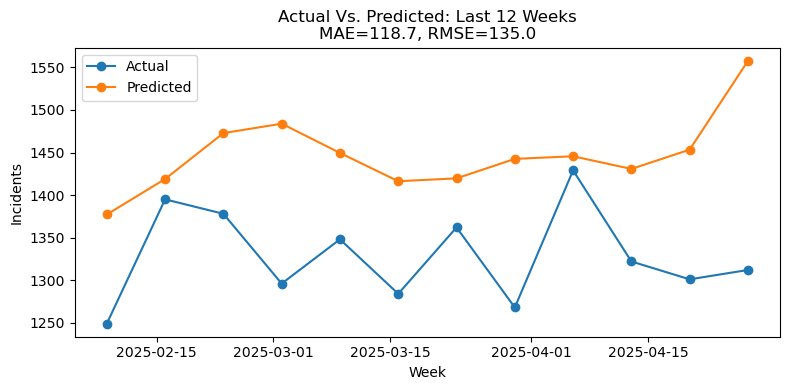

In [18]:
#Back-test: last 12 weeks actual vs predicted
eval_base = (
    forecast_base.set_index("ds")[["yhat"]]
      .join(prophet_df.set_index("ds"))
      .dropna()
)

eval_last12 = eval_base.tail(12)

mae_b  = mean_absolute_error(eval_last12["y"], eval_last12["yhat"])
rmse_b = mean_squared_error(eval_last12["y"], eval_last12["yhat"], squared=False)

plt.figure(figsize=(8,4))
plt.plot(eval_last12.index, eval_last12["y"],    label="Actual",  marker='o')
plt.plot(eval_last12.index, eval_last12["yhat"], label="Predicted", marker='o')
plt.title(f"Actual Vs. Predicted: Last 12 Weeks\nMAE={mae_b:.1f}, RMSE={rmse_b:.1f}")
plt.xlabel("Week")
plt.ylabel("Incidents")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
top_cats = (
    df["Offense Category"]
      .value_counts()
      .index
      .tolist()
)
print("Forecasting these categories:", top_cats)

Forecasting these categories: ['PROPERTY CRIME', 'ALL OTHER', 'VIOLENT CRIME']


In [20]:
cat_forecasts = {}

for cat in top_cats:
    df_cat = df[df["Offense Category"] == cat]
    weekly_cat = (
        df_cat.set_index("Offense Date")
              .resample("W", label="left")
              .size()
              .reset_index(name="y")
              .rename(columns={"Offense Date":"ds"})
    )
    weekly_cat = weekly_cat.iloc[:-1]

    m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    m.fit(weekly_cat)

    future = m.make_future_dataframe(periods=12, freq="W")
    fc     = m.predict(future)

    cat_forecasts[cat] = (weekly_cat, fc)

21:55:09 - cmdstanpy - INFO - Chain [1] start processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] start processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing


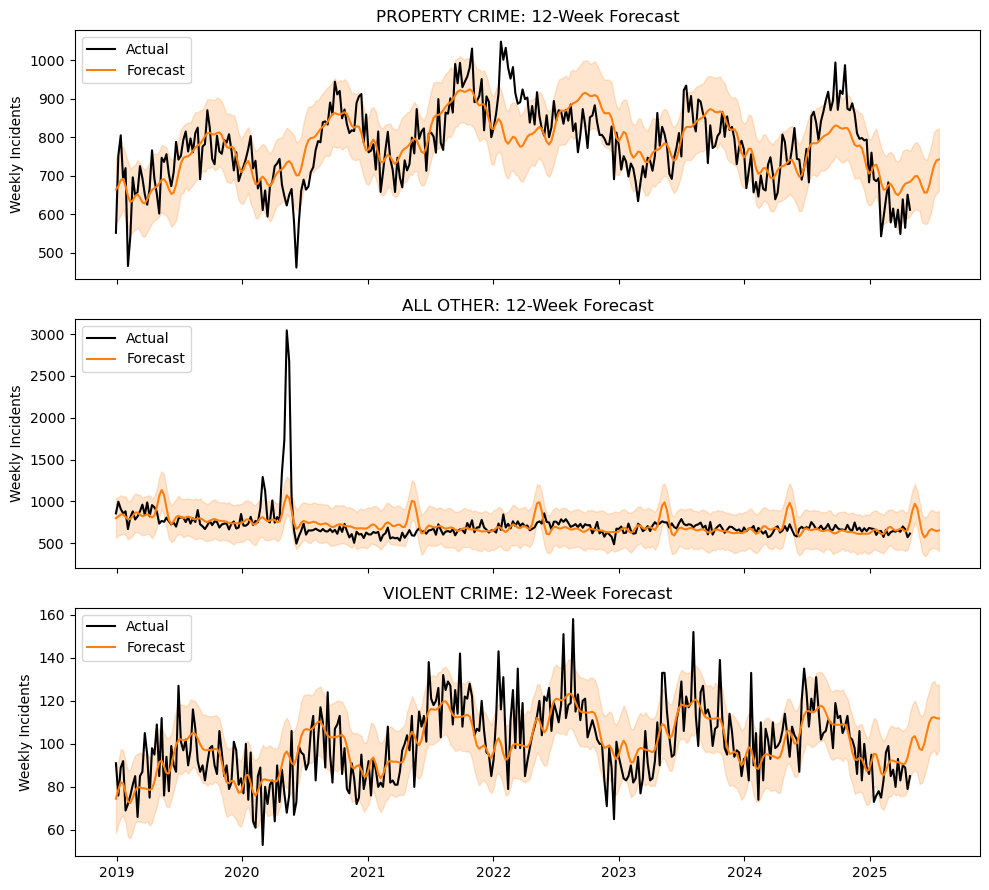

In [21]:
n = len(top_cats)
fig, axes = plt.subplots(n, 1, figsize=(10, 3*n), sharex=True)

for ax, cat in zip(axes, top_cats):
    hist, fc = cat_forecasts[cat]
    ax.plot(hist["ds"], hist["y"], label="Actual", color="black")
    ax.plot(fc["ds"], fc["yhat"], label="Forecast", color="C1")
    ax.fill_between(fc["ds"], fc["yhat_lower"], fc["yhat_upper"], 
                    color="C1", alpha=0.2)
    ax.set_title(f"{cat}: 12-Week Forecast")
    ax.set_ylabel("Weekly Incidents")
    ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

## 4. Conclusion & Next Steps

**Key Findings:**  
- **Seasonal trends:** Weekly incident counts show pronounced summer peaks and winter troughs
- **Weekday patterns:** Crime volume is highest on Fridays and lowest on Sundays
- **Neighborhood hotspots:** Top 10 neighborhoods by crime volume identified key patrol areas 
- **Offense breakdown:** LARCENY-THEFT and BURGLARY dominate, with the top 10 sub-categories accounting for over 50% of incidents
- **Forecast insights:** Prophet models captured baseline trends and produced actionable 12-week forecasts for the main crime categories

**Next Steps:**  
1. Evaluate other forecasting methods and compare error metrics.  
2. Incorporate external covariates (weather, events, socio-economic data) to improve accuracy.  
3. Build an interactive dashboard (e.g., Plotly Dash, Tableau) for stakeholders to explore trends and forecasts.  
4. Once geospatial data is available, identify crime hotspots for targeted interventions.